## Reporte: Comparación de variables en poblaciones pediátricas y no pediátricas

Los archivos en esta carpeta permiten generar las ilustraciones y tablas asociados al reporte *Comparación de variables en poblaciones pediátricas y no pediátricas* realizado en el marco del proyecto FONDEF ID23I10423 
*Sistema informático en base a inteligencia artificial para predecir peak de hospitalizaciones pediátricas por causas respiratorias*.

In [1]:
## Importar librerias necesarias
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import duckdb

In [2]:
periodo = 365

year = "(2019)"

macrozona_norte = """(1,2,3,4)"""
macrozona_centro = """(5,6,7,8)"""
region_metropolitana = """(9,10,11,12,13,14)"""
macrozona_centro_sur = """(15,16,17,18,19,20,28)"""
macrozona_sur = """(21,22,23,24,29,33)"""
macrozona_austral = """(25,26)"""

lista_zonas_servicios_salud = [macrozona_norte,
                macrozona_centro,
                region_metropolitana,
                macrozona_centro_sur,
                macrozona_sur,
                macrozona_austral]

lista_zonas = ["MacrozonaNorte",
               "MacrozonaCentro",
               "RegionMetropolitana",
               "MacrozonaCentroSur",
               "MacrozonaSur",
               "MacrozonaAustral"]

lista_zonas_legend = ["Macrozona Norte",
               "Macrozona Centro",
               "Region Metropolitana",
               "Macrozona Centro-Sur",
               "Macrozona Sur",
               "Macrozona Austral"]

grupo_etario_list=["Menores_1","De_1_a_4","De_5_a_14","De_15_a_64","De_65_y_mas"]
grupo_etario_list_titles=["Menores 1","De 1 a 4","De 5 a 14","De 15 a 64","De 65 y más"]

Gráfica correspondiente al año (2019)


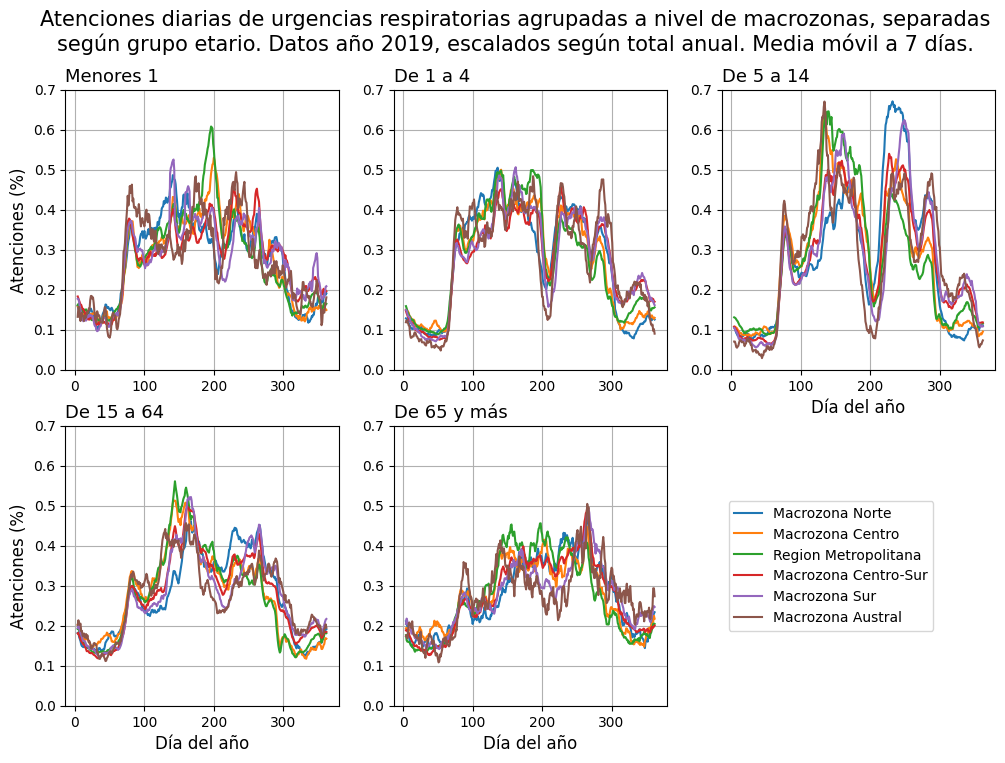

In [3]:
# ILUSTRACIÓN 4 ATENCIONES DIARIAS DE URGENCIA PARA 
# CADA DÍA DEL AÑO CORRESPONDIENTES AL PERIODO 2017 -2023 para diferentes zonas geográficas 

#Genera una comparación de las atenciones diarias correspondiente 
# a diferentes regiones geográficas. Las zonas están determinadas 
# por lo servicios de salud que las componen
# en los gráficos se muestra la información para diferentes grupos etarios


print("Gráfica correspondiente al año " + year)

query_list = []
for k, servicios_zona, nombre_zona in zip([k for k in range(len(lista_zonas_servicios_salud))],lista_zonas_servicios_salud,lista_zonas):
    query_list.append("""
SELECT year(strptime(fecha, '%d/%m/%Y')) as year
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia 
    ,""" + "'"  + nombre_zona + "'" + """ as zona
    , sum(Menores_1)  as Menores_1
    , sum(De_1_a_4)  as De_1_a_4
    , sum(De_5_a_14)  as De_5_a_14
    , sum(De_15_a_64)   as De_15_a_64
    , sum(De_65_y_mas) as De_65_y_mas
FROM datos_urgencia_consolidados.parquet
where IdCausa in (3,4,5,6,10,11)
and year(strptime(fecha, '%d/%m/%Y')) in""" + year + """
--and year(strptime(fecha, '%d/%m/%Y')) in (2017,2018,2019,2022,2023)
and CodigoDependencia in """ + servicios_zona +"""
group by zona, fecha
having dayofyear(strptime(fecha, '%d/%m/%Y')) <= """+ str(periodo) + """
""")
    if k +1< len(lista_zonas_servicios_salud):
        query_list.append(""" UNION """)

df2 = duckdb.sql(''.join(query_list)).df()


df2 = df2.sort_values(by=['zona','year','nrodia']).reset_index(drop = True)
df3 = pd.concat([df2[["zona","year","nrodia","Menores_1"]].rename(columns={"Menores_1":"atenciones"}).assign(grupo_etario = "Menores_1"),
df2[["zona","year","nrodia","De_1_a_4"]].rename(columns={"De_1_a_4":"atenciones"}).assign(grupo_etario = "De_1_a_4"),
df2[["zona","year","nrodia","De_5_a_14"]].rename(columns={"De_5_a_14":"atenciones"}).assign(grupo_etario = "De_5_a_14"),
df2[["zona","year","nrodia","De_15_a_64"]].rename(columns={"De_15_a_64":"atenciones"}).assign(grupo_etario = "De_15_a_64"),
df2[["zona","year","nrodia","De_65_y_mas"]].rename(columns={"De_65_y_mas":"atenciones"}).assign(grupo_etario = "De_65_y_mas")
])


#fig = plt.figure(figsize = (12,14))
fig = plt.figure(figsize = (12,8))
fig.suptitle('Atenciones diarias de urgencias respiratorias agrupadas a nivel de macrozonas, separadas\nsegún grupo etario. Datos año 2019, escalados según total anual. Media móvil a 7 días.', fontsize=15)


for k in range(5):
    df4 =df3[df3["grupo_etario"]==grupo_etario_list[k]]
    ax = fig.add_subplot(2,3,k+1) 
    df_dict = {key[0]: d for key, d in df4[['zona','year','nrodia','atenciones']].groupby(['zona'])}
    ax.set_prop_cycle(color = plt.get_cmap("tab10").colors)
    for key in lista_zonas:
        plt.plot(df_dict[key]['nrodia'],100*df_dict[key]['atenciones'].rolling(7,center=True).mean()/float(sum(df_dict[key]['atenciones'])) )

    ax.set_ylim(ymin=0)
    ax.set_ylim(ymax=0.7)
    ax.grid()
    ax.set_title(str(grupo_etario_list_titles[k]) , fontsize = 13, loc='left')
    if k in (2,3,4):
        ax.set_xlabel('Día del año', fontsize = 12)
    if k in (0,3):
        ax.set_ylabel('Atenciones (%)', fontsize = 12)

#show legend in last plot space
ax = fig.add_subplot(2,3,6) 
ax.set_prop_cycle(color = plt.get_cmap("tab10").colors)
for key in lista_zonas:
   plt.plot(range(1),range(1))

ax.legend(lista_zonas_legend,loc='center left',fontsize = 10 )
ax.axis('off')
plt.savefig('fig4_v2_urgencias_geografica_grupo_etario_2019.png', bbox_inches='tight')